# MSDS7333 Case Study 2: Signal Frontier Analysis

#### Team Members: Cory Nichols, Dennis Murray, Jared Law, Julien Bataillard



<a id='abstract'></a>
## 1 - Abstract

This case study recreates the signal frontier analysis from [1] by exploring a "simplified" cross-sectional momentum portfolio. This strategy consists of picking high return stocks from the previous 3-12 months and getting rid of underperforming ones over the same time period, hence the momentum. These portfolios tend to perform well for the following 12 months at the most. The study applies to only 5 stocks (different from the textbook) from the fast food industry and the results are close to the example in terms of high rate of return and holding period values. 

<a id='introduction'></a>
## 2 - Introduction





In [55]:
# Import required libraries / modules

import datetime as dt
import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import data as web
from pandas_datareader.yahoo.daily import YahooDailyReader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# check library versions

print('pandas', pd.__version__)
print('numpy', np.__version__)
print('seaborn', sns.__version__)
print('matplotlib', mpl.__version__)
print('pandas_datareader', pdr.__version__)

pandas 0.22.0
numpy 1.14.0
seaborn 0.8.0
matplotlib 2.1.2
pandas_datareader 0.5.0


<a id="methods"></a>
## 3 - Methods

In [57]:
# set date range
date_time_start = dt.datetime(2016, 1, 1)
date_time_end = dt.datetime(2017, 6, 1)

In [58]:
def get_portfolio():
    ''' Get portfolio of stocks using buggy Yahoo'''
    
    port = pd.DataFrame()
    names = ['DPZ', 'PZZA', 'YUM', 'FRSH', 'MCD', 'KHC', 'PLAY']
    # Domino's, Papa John's, Yum Brands, Papa Murphy's, McDonalds, Kraft Heinz, Dave and Buster's
    for stock in names:
        while True:
            try:
                port[stock] = web.get_data_yahoo(stock, date_time_start, date_time_end)['Adj Close']
                break
            except:
                print('Unable to read stock: {0}, trying again'.format(stock))
    return port

sp = get_portfolio()

Unable to read stock: FRSH, trying again
Unable to read stock: MCD, trying again


In [59]:
# daily adjusted close prices for pizza portfolio
sp.head()


,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
Date,,,,,,,
2016-01-04,107.016136,53.639576,49.635929,10.92,111.198700,68.692657,41.709999
2016-01-05,107.701935,53.414898,49.512199,10.77,112.730759,69.344627,41.889999
2016-01-06,107.545174,51.363480,49.161636,11.23,111.974197,69.476913,42.439999
2016-01-07,104.586395,49.546516,47.484421,10.71,109.382896,67.936745,41.209999
2016-01-08,106.761391,47.504875,46.838276,10.26,109.212654,67.256439,39.509998


In [60]:
# pepperoni pizza?
sp.describe()


,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,150.081639,70.684679,60.116682,6.822717,119.307897,82.016308,47.435770
std,26.632106,12.199153,5.646775,2.500708,8.940297,6.572037,9.581822
min,102.048889,44.447296,45.143360,3.780000,106.960632,65.385567,31.080000
25%,128.977921,59.137615,56.927414,4.650000,112.730759,78.209389,39.470001
50%,148.811310,74.692879,61.966843,6.030000,117.558563,84.319641,45.330002
75%,169.237442,79.682266,63.460941,8.475000,122.494331,86.370911,56.189999
max,216.474655,88.525841,73.412682,12.810000,151.927551,93.931450,68.639999


In [61]:
# check linear relationships
corr = sp.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)

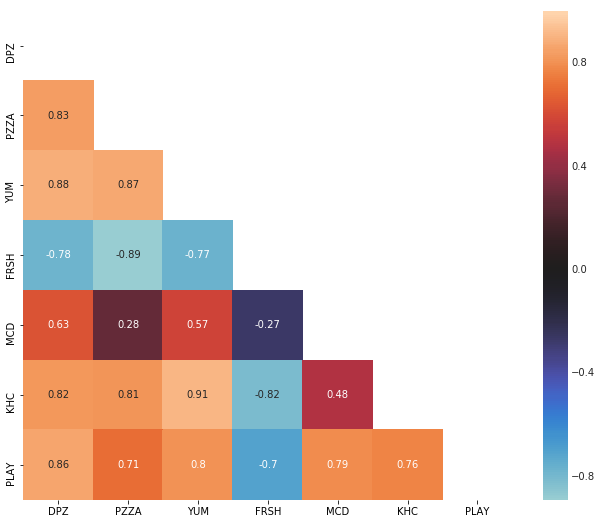

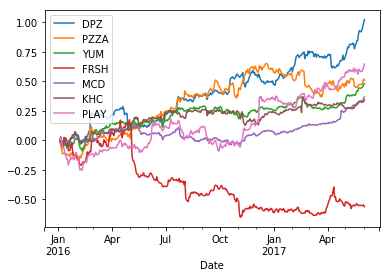

In [62]:
# transform to business day frequency and calculate percentage change
# show cumulative returns over time period of business days
sp = sp.asfreq('B').fillna(method='pad') # pad == ffill
rets = sp.pct_change(1)
((1+rets).cumprod()-1).plot()
plt.show()
# papa murphy's is hurtin'

In [63]:
# potential reference: https://www.investopedia.com/terms/m/momentum_investing.asp
# compute momentum over a lookback and rank in descending order and standardize

def calc_meanRev(price, lookback, lag):
    '''Calculates pct change based on user input shift and lookback period, ranks, then standardized ranks'''
    meanRev = price.shift(lag).pct_change(lookback) # price shift forward lag periods and calc % change at lookback
    ranks = meanRev.rank(axis=1, ascending=False) # rank top 
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [64]:
compound = lambda x : (1+x).prod()-1
daily_sr = lambda x : x.mean() / x.std() # calculate mean portfolio return divided by std deviation
# Sharpe Ratio is avg return above risk free rate 
# Subtracting the risk-free rate from the mean return, 
# the performance associated with risk-taking activities can be isolated.
# > sharpe ratio = more attractive risk adjusted return
# (https://www.investopedia.com/terms/s/sharperatio.asp)

def strat_sr(prices, lb, hold):
    '''prices = portfolio, lb = lookback, hold = holding period for portfolio (days between trading)'''
    freq = '%dB' % hold # placeholder for holding period
    port = calc_meanRev(prices, lb, lag=1) # get ranked and standardized momentum portfolio back
    
    daily_rets = prices.pct_change() # get daily returns
    
    port = port.shift(1).resample(freq).first() # shift portfolio and resample based on holding period
                                                # take first value avail based on freq for the ranking
    returns = daily_rets.resample(freq).apply(compound)  # results: mean returns over frequency grouped periods
                                                         # compounded daily
    port_rets = (port * returns).sum(axis=1)             # momentum portfolio returns, weighted
    
    return daily_sr(port_rets) * np.sqrt(252/hold)       # sharpe ratio (sans risk free rate here)
                                                         # multiplied by compounded periods

In [65]:
strat_sr(sp, 70, 30)

-0.6871485159555324

In [66]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(sp, lb, hold)
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [67]:

def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

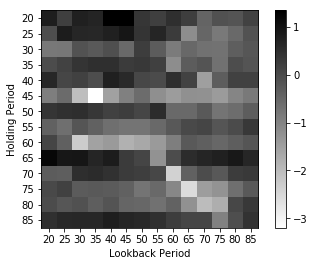

In [68]:
heatmap(ddf)
plt.show()

<a id="results"></a>
## 4 - Results

<a id="conclusion"></a>
## 5 - Conclusion and future work

<a id="conclusion"></a>
## 6 - References